<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.

# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>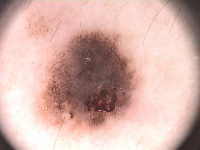</td><td>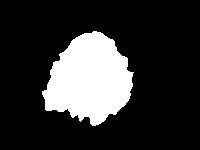</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Я использую kaggle notebook, поэтому следующие две строки кода мне не понадобятся, так как я вручную загрузил датасет и kaggle сам его распаковал.

In [1]:
#!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [2]:
#get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/kaggle/input/ph2-dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.

In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

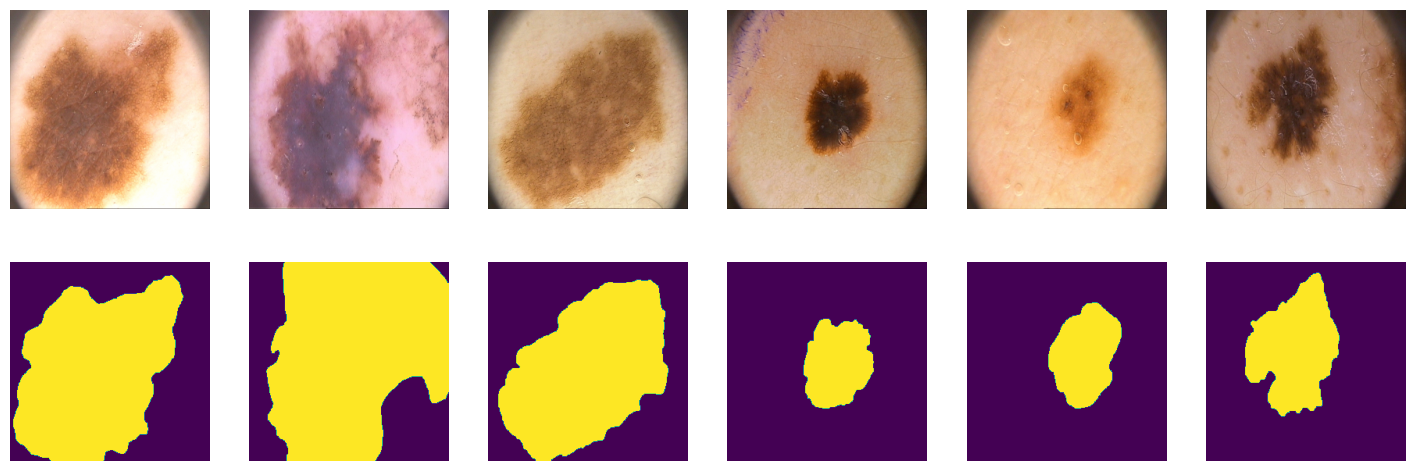

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:




<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
!pip install torchmetrics

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]


Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

Не знаю в каком формате здесь должен быть ответ, надеюсь будет всё понятно в печатном виде:

**Ответ:** [1] = -(y*ln(1/(1+e^(-ŷ)))+(1-y)*ln(1-1/(1+e^(-ŷ)))) =  -(y*(-ln(1+e^(-ŷ)))+(1-y)*ln(e^(-ŷ)/(1+e^(-ŷ)))) = -(y*(-ln(1+e^(-ŷ)))+(1-y)*(ln(e^(-ŷ))-ln(1+e^(-ŷ)))) = -(y*(-ln(1+e^(-ŷ)))+(1-y)*(-ŷ-ln(1+e^(-ŷ)))) = y*ln(1+e^(-ŷ))+ŷ+ln(1+e^(-ŷ))-y*ŷ-y*ln(1+e^(-ŷ)) = ŷ-y*ŷ+ln(1+e^(-ŷ))

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [16]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_pred * y_real + np.log(1+np.exp(-y_pred)))

def bce_true(y_pred, y_real):
  return torch.sum(-(y_real * np.log(sigmoid(y_pred)) + (1 - y_real) * np.log(1 - sigmoid(y_pred))))

Проверим корректность работы на простом примере

In [17]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')

BCE loss from scratch bce_loss = 4.962095260620117
BCE loss честно посчитанный = 4.962095260620117
BCE loss from torch bce_torch = 4.962095260620117
BCE loss from torch with logits bce_torch = 4.962095260620117


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [18]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [19]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.68769359588623
BCE loss честно посчитанный = 13.687695503234863
BCE loss from torch bce_torch = 13.68769359588623
BCE loss from torch with logits bce_torch = 13.68769359588623


In [20]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [21]:
!pip install gdown

In [22]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 3.02MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 6.60MB/s]
Download completed


In [23]:
path_to_dummy_samples = '/kaggle/working/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

/tmp/ipykernel_30/3135398490.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
/tmp/ipykernel_

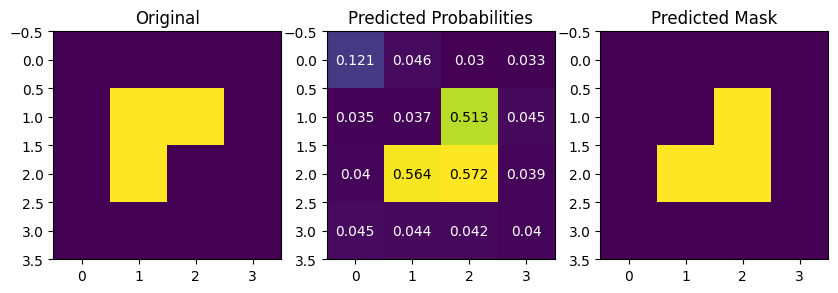

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [25]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

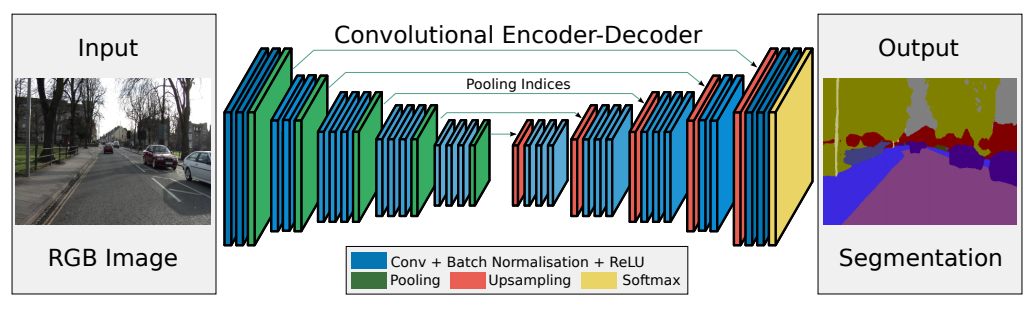

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239

Напишу здесь насчёт bottleneck: вроде как на картинке bottleneck отсутсвует, да и посмотрев готовые коды SegNet'a не нашёл ничего про bottleneck, разве, что в статье выше он используется. В принципе смысл его работы понятен, но не до конца, если вдруг это кто-то читает, и сможет на простом языке объяснить, буду очень благодарен)  
По крайней мере погуглив, не очень понимаю как работает данная реализация bottleneck'a, исходя из всего вышесказанного закомменчу код с ним. Прошу не снижать за это баллы, если вообще в критериях что-то есть про реализацию bottleneck'a.

In [27]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # VGG-16 architecture
        self.PoolEn = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.ConvEn11 = nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(num_features=64)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(num_features=64)
        
        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(num_features=128)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(num_features=128)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(num_features=256)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(num_features=256)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(num_features=256)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(num_features=512)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(num_features=512)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(num_features=512)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512)
        
        # bottleneck
        #self.bottleneck_conv1 = nn.Conv2d(512, 128, kernel_size=1)
        #self.bottleneck_BN1 = nn.BatchNorm2d(num_features=128)
        #self.bottleneck_conv2 = nn.Conv2d(128, 128, kernel_size=3)
        #self.bottleneck_BN2 = nn.BatchNorm2d(num_features=128)
        #self.bottleneck_conv3 = nn.Conv2d(128, 512, kernel_size=1)
        #self.bottleneck_BN3 = nn.BatchNorm2d(num_features=512)

        # decoder (upsampling)
        self.PoolDe = nn.MaxUnpool2d(2, stride=2)

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64)
        self.ConvDe11 = nn.Conv2d(64, self.out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x)))
        size1 = x.size()
        x, ind1 = self.PoolEn(x)

        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        size2 = x.size()
        x, ind2 = self.PoolEn(x)

        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))  
        size3 = x.size()
        x, ind3 = self.PoolEn(x)

        x = F.relu(self.BNEn41(self.ConvEn41(x))) 
        x = F.relu(self.BNEn42(self.ConvEn42(x))) 
        x = F.relu(self.BNEn43(self.ConvEn43(x)))
        size4 = x.size()
        x, ind4 = self.PoolEn(x)

        x = F.relu(self.BNEn51(self.ConvEn51(x))) 
        x = F.relu(self.BNEn52(self.ConvEn52(x))) 
        x = F.relu(self.BNEn53(self.ConvEn53(x)))
        size5 = x.size()
        x, ind5 = self.PoolEn(x)

        # bottleneck
        #x = F.relu(self.bottleneck_BN1(self.bottleneck_conv1(x))) 
        #x = F.relu(self.bottleneck_BN2(self.bottleneck_conv2(x))) 
        #x = F.relu(self.bottleneck_BN3(self.bottleneck_conv3(x))) 

        # decoder
        x = self.PoolDe(x, ind5, output_size=size5)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        x = self.PoolDe(x, ind4, output_size=size4)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        x = self.PoolDe(x, ind3, output_size=size3)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        x = self.PoolDe(x, ind2, output_size=size2)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        x = self.PoolDe(x, ind1, output_size=size1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        #x = F.softmax(x, dim=1)

        return x # no activation

In [28]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [29]:
from tqdm.notebook import tqdm

Здесь сделаю функцию train_val, вместо train_val, чтобы сразу проверять лоссы и метрику на валидационной выборке.

In [30]:
train_losses = []
val_losses = []
train_iou = []
val_iou = []
epochs_ = []

def train_val(model, optimizer, criterion, epochs, train_dataloader, val_dataloader, device):
    for epoch in tqdm(range(epochs)):
        model.train()
        avg_loss = 0
        processed_data = 0
        iou = 0
        for i, (X_batch, Y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            y_pred = F.sigmoid(Y_pred)
            iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)
            
            avg_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        epoch_loss = avg_loss / processed_data
        train_losses.append(epoch_loss)
        train_iou.append(iou / processed_data)

        model.eval()
        avg_loss = 0
        processed_data = 0
        iou = 0
        for i, (X_batch, Y_batch) in enumerate(val_dataloader):
            with torch.no_grad():
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = criterion(Y_pred, Y_batch)

                y_pred = F.sigmoid(Y_pred)
                iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)
    
            avg_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        epoch_loss = avg_loss / processed_data
        val_losses.append(epoch_loss)
        val_iou.append(iou / processed_data)

        epochs_.append(epoch+1)

In [31]:
def graph(train_losses, val_losses, train_iou, val_iou, epochs):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    # Сравнение лоссов:
    ax1.plot(epochs, train_losses, label="Train Loss")
    ax1.plot(epochs, val_losses, label="Validation Loss")
    ax1.set_title("Loss Comparison")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid()

    # Сравнение метрик:
    ax2.plot(epochs, train_iou, label="Train iou")
    ax2.plot(epochs, val_iou, label="Validation iou")
    ax2.set_title("IOU Comparison")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("IOU")
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

Почему-то не работает tqdm здесь. Надеюсь кто-то подскажет, что я делаю не так...

In [32]:
# TODO
opt = torch.optim.Adam(segnet_model.parameters(), lr=1e-4)

train_val(segnet_model, opt, bce_torch_with_logits, 50, train_dataloader, valid_dataloader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

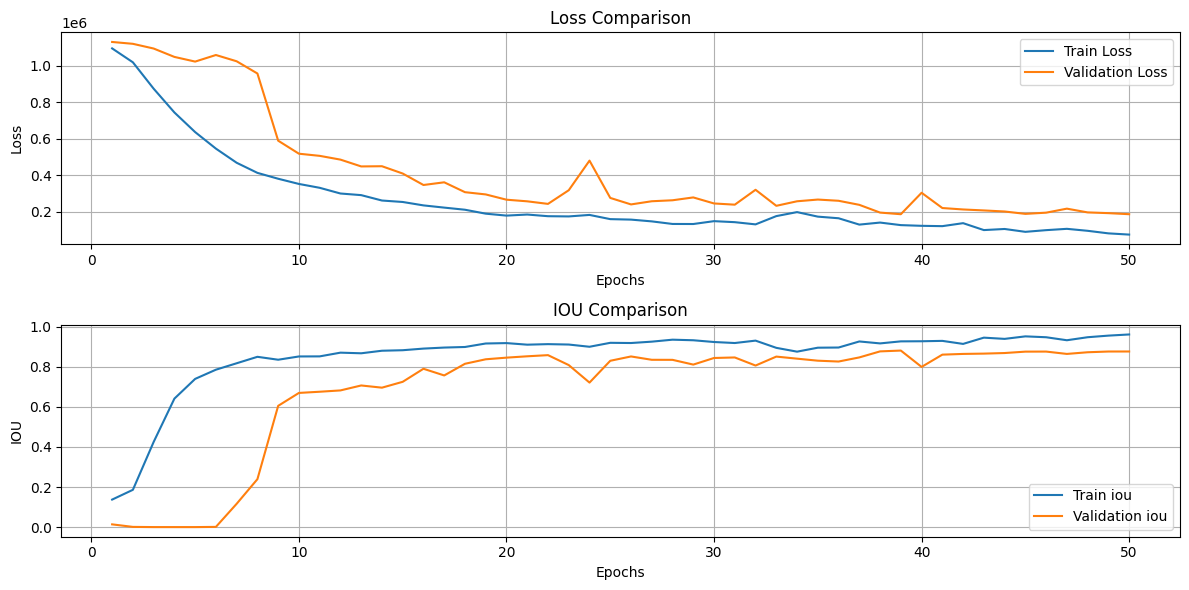

In [33]:
graph(train_losses, val_losses, train_iou, val_iou, epochs_)

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [34]:
def test(model, criterion, test_dataloader, device):
    model.eval()
    avg_loss = 0
    processed_data = 0
    iou = 0
    for i, (X_batch, Y_batch) in enumerate(test_dataloader):
        with torch.no_grad():
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)

            y_pred = F.sigmoid(Y_pred)
            iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)

        avg_loss += loss.item() * X_batch.size(0)
        processed_data += X_batch.size(0)
    loss_all = avg_loss / processed_data
    iou_test = iou / processed_data
    #print(f"Average Loss: {loss_all:.4f}")
    #print(f"Average IOU: {iou_test:.4f}")
    return iou_test

In [35]:
iou = test(segnet_model, bce_torch_with_logits, test_dataloader, device)
print(f"Average IOU: {iou:.4f}")

Average IOU: 0.8487


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.

### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [36]:
eps = 1e-8

def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    pred = F.sigmoid(logits)
    pred = pred >= threshold
    TP = torch.sum(pred * labels)
    FP = torch.sum(pred) - TP
    FN = torch.sum(labels) - TP
    score = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    return score

Проверим на корректность функцию dice_score:

In [37]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [38]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [39]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    pred = F.sigmoid(logits)
    TP = torch.sum(pred * labels)
    FP = torch.sum(pred) - TP
    FN = torch.sum(labels) - TP
    score = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    loss = 1 - score
    
    return loss

Проверка на корректность:

In [40]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.2 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=393aa9c2f33d3c1eeea5bc4723ee61550239d6172cfd76c57052e3e384497096
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f3481e338c35695696ed4ad00927e9baf649753f004b59ef0ec09cd98e2e572a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [41]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [42]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [43]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    bce_loss_ = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
    p = F.sigmoid(y_pred) * y_real + (1 - F.sigmoid(y_pred)) * (1 - y_real)
    loss = torch.sum(torch.pow((1-p), gamma) * bce_loss_)
    return loss

Проверка корректности функции:

In [44]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [45]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Я реализую Tversky Loss:

In [46]:
def tversky_loss(y_pred, y_true, alpha=0.5, beta=0.5, eps=1e-8):
    y_pred = torch.sigmoid(y_pred)
    #y_pred = y_pred.view(-1)
    #y_true = y_true.view(-1)
    TP = torch.sum(y_true * y_pred)
    FP = torch.sum((1 - y_true) * y_pred)
    FN = torch.sum(y_true * (1 - y_pred))
    tversky_index = TP / (TP + alpha * FP + beta * FN + eps)
    loss = 1 - tversky_index
    return loss


Сравню свою реализацию с pytorch:

In [47]:
from segmentation_models_pytorch.losses import TverskyLoss
tversky_loss_torch = TverskyLoss(mode="binary")
tversky_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [48]:
assert tversky_loss_torch(dummpy_sample['logits'], dummpy_sample['labels']) == tversky_loss(dummpy_sample['logits'], dummpy_sample['labels'])

Dice Loss по сути частный случай Tversky лосса (при альфа = бета = 0.5), проверим и это:

In [49]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels']) == tversky_loss(dummpy_sample['logits'], dummpy_sample['labels'])

Tversky Loss достаточно гибкий, но требует настройки параметров альфа и бета, что может быть не очень очевидно. Конкретно в нашей задаче я могу предположить, что FN (пропущенный диагноз) имеет большую значимость, поэтому параметр бета стоит выбирать больше (альфа + бета = 1 считается балансом между FP и FN). В общем вот так, включать этот Loss в дальнейшее исследование не буду, этого вроде и не просят, да и возможно придётся повозиться с подбором альфы и беты, а делаю этот пункт в последнюю очередь. В дальнейшем для себя очень интересно будет сравнить с другими лоссами, сейчас уже не успеваю до дедлайна...

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.


Для BCE у нас уже есть всё необходимое (из прошлого пункта). Обучим сначала на DICE Loss:

In [50]:
segnet_model_dice = SegNet().to(device)

train_losses_dice = []
val_losses_dice = []
train_iou_dice = []
val_iou_dice = []

def train_val(model, optimizer, criterion, epochs, train_dataloader, val_dataloader, device):
    for epoch in tqdm(range(epochs)):
        model.train()
        avg_loss = 0
        processed_data = 0
        iou = 0
        for i, (X_batch, Y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            y_pred = F.sigmoid(Y_pred)
            iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)
            
            avg_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        epoch_loss = avg_loss / processed_data
        train_losses_dice.append(epoch_loss)
        train_iou_dice.append(iou / processed_data)
        #print(f"Epoch {epoch+1}, Average Loss: {epoch_loss:.4f}")

        model.eval()
        avg_loss = 0
        processed_data = 0
        iou = 0
        for i, (X_batch, Y_batch) in enumerate(val_dataloader):
            with torch.no_grad():
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = criterion(Y_pred, Y_batch)

                y_pred = F.sigmoid(Y_pred)
                iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)
    
            avg_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        epoch_loss = avg_loss / processed_data
        val_losses_dice.append(epoch_loss)
        val_iou_dice.append(iou / processed_data)
        #print(f"Average Val Loss: {loss_all:.4f}")

In [51]:
opt = torch.optim.Adam(segnet_model_dice.parameters(), lr=1e-4)
train_val(segnet_model_dice, opt, dice_loss, 50, train_dataloader, valid_dataloader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

Построю графики для DICE Loss:

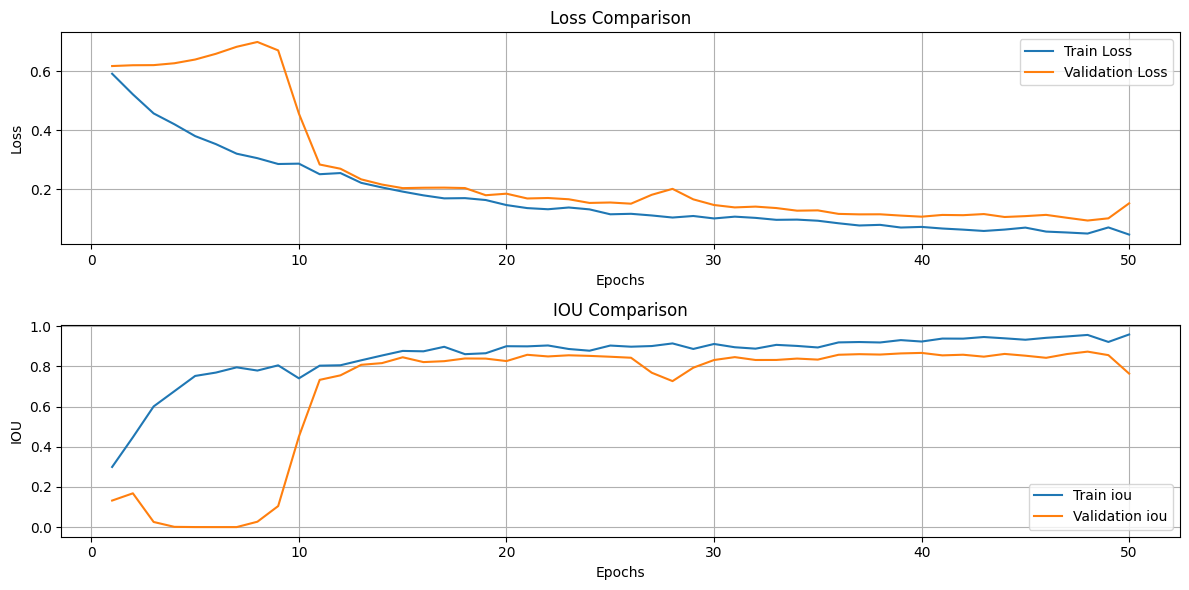

In [52]:
graph(train_losses_dice, val_losses_dice, train_iou_dice, val_iou_dice, epochs_)

Теперь обучим на focal loss:

In [53]:
segnet_model_focal = SegNet().to(device)

train_losses_focal = []
val_losses_focal = []
train_iou_focal = []
val_iou_focal = []

def train_val(model, optimizer, criterion, epochs, train_dataloader, val_dataloader, device):
    for epoch in tqdm(range(epochs)):
        model.train()
        avg_loss = 0
        processed_data = 0
        iou = 0
        for i, (X_batch, Y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            y_pred = F.sigmoid(Y_pred)
            iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)
            
            avg_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        epoch_loss = avg_loss / processed_data
        train_losses_focal.append(epoch_loss)
        train_iou_focal.append(iou / processed_data)
        #print(f"Epoch {epoch+1}, Average Loss: {epoch_loss:.4f}")

        model.eval()
        avg_loss = 0
        processed_data = 0
        iou = 0
        for i, (X_batch, Y_batch) in enumerate(val_dataloader):
            with torch.no_grad():
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = criterion(Y_pred, Y_batch)

                y_pred = F.sigmoid(Y_pred)
                iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)
    
            avg_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        epoch_loss = avg_loss / processed_data
        val_losses_focal.append(epoch_loss)
        val_iou_focal.append(iou / processed_data)
        #print(f"Average Val Loss: {loss_all:.4f}")

In [54]:
opt = torch.optim.Adam(segnet_model_focal.parameters(), lr=1e-4)
train_val(segnet_model_focal, opt, focal_loss, 50, train_dataloader, valid_dataloader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

Построю графики для Focal Loss:

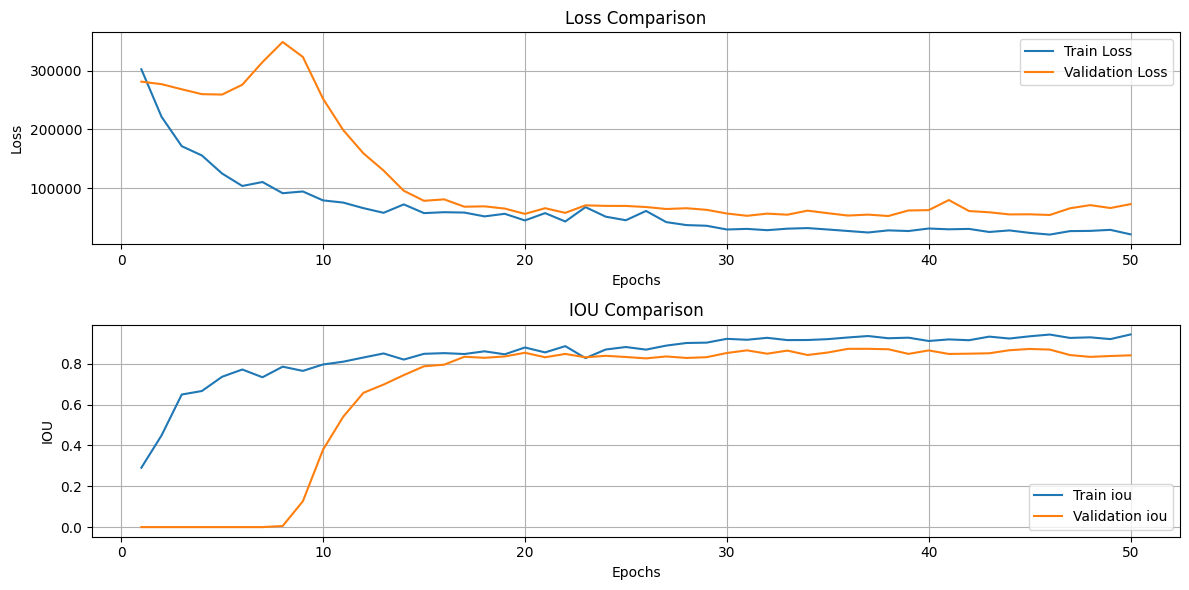

In [55]:
graph(train_losses_focal, val_losses_focal, train_iou_focal, val_iou_focal, epochs_)

Графики сравнения трёх лоссов (для dice loss'a стоит смотреть на отдельном для него графике, т.к. его диапазон значений намного меньше):

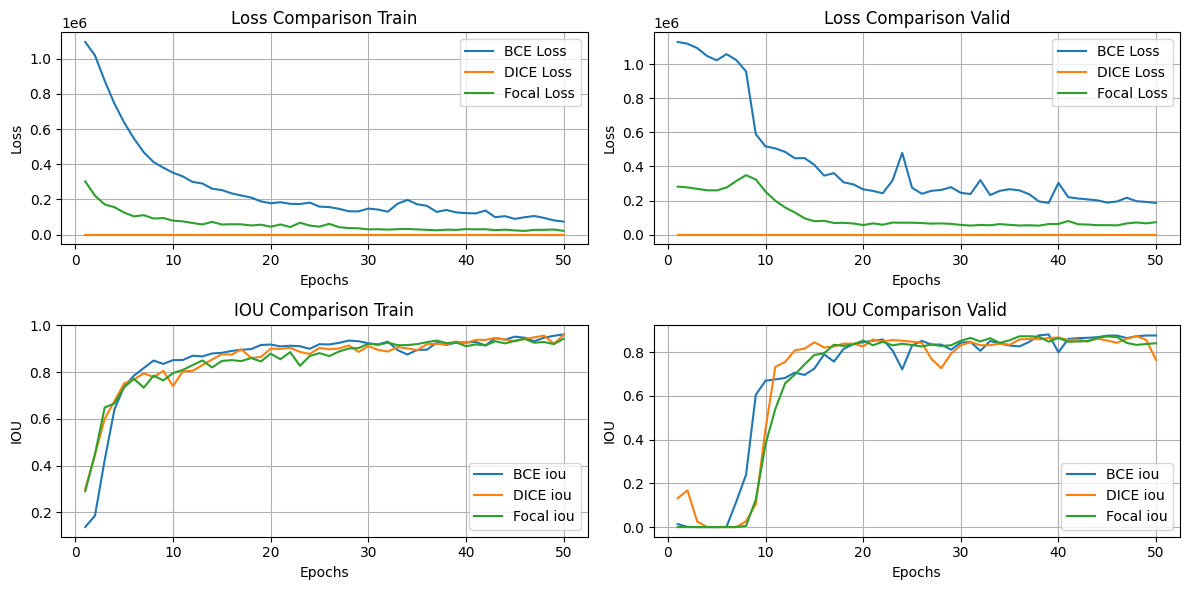

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

(ax1, ax2), (ax3, ax4) = axes

# Сравнение лоссов на трейне:
ax1.plot(epochs_, train_losses, label="BCE Loss")
ax1.plot(epochs_, train_losses_dice, label="DICE Loss")
ax1.plot(epochs_, train_losses_focal, label="Focal Loss")
ax1.set_title("Loss Comparison Train")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid()

# Сравнение лоссов на валидации:
ax2.plot(epochs_, val_losses, label="BCE Loss")
ax2.plot(epochs_, val_losses_dice, label="DICE Loss")
ax2.plot(epochs_, val_losses_focal, label="Focal Loss")
ax2.set_title("Loss Comparison Valid")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid()

# Сравнение метрик IOU на трейне:
ax3.plot(epochs_, train_iou, label="BCE iou")
ax3.plot(epochs_, train_iou_dice, label="DICE iou")
ax3.plot(epochs_, train_iou_focal, label="Focal iou")
ax3.set_title("IOU Comparison Train")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("IOU")
ax3.legend()
ax3.grid()

# Сравнение метрик IOU на валидации:
ax4.plot(epochs_, val_iou, label="BCE iou")
ax4.plot(epochs_, val_iou_dice, label="DICE iou")
ax4.plot(epochs_, val_iou_focal, label="Focal iou")
ax4.set_title("IOU Comparison Valid")
ax4.set_xlabel("Epochs")
ax4.set_ylabel("IOU")
ax4.legend()
ax4.grid()

plt.tight_layout()
plt.show()

На самом деле графики оказались не очень информативными)  
Про сходимость: на BCE лоссе модель начала сходиться где-то на 12 эпохе судя по графику (лучше выглядят отдельные графики, так как у лоссов разные масштабы), у DICE лосса ситуация аналогичная, но в отличие от BCE, у DICE лосс далее вроде более стабильный, у BCE же он чуть больше уменьшается, и под конец как будто прослеживается небольшое переобучение. Focal лосс же сходится где-то на 15 эпохе, судя по его графику.  
ОТВЕТ: Скорее всего DICE Loss (примерно на равне с BCE)
Про лучшее значение метрики: тут думаю репрезентативнее будет проверить на тесте, далее напишу ответ и после - нужный код.  
ОТВЕТ: BCE Loss показал лучший результат

In [57]:
iou_BCE = test(segnet_model, bce_torch_with_logits, test_dataloader, device)
print(f"BCE IOU: {iou_BCE:.4f}")
iou_DICE = test(segnet_model_dice, dice_loss, test_dataloader, device)
print(f"DICE IOU: {iou_DICE:.4f}")
iou_focal = test(segnet_model_focal, focal_loss, test_dataloader, device)
print(f"Focal IOU: {iou_focal:.4f}")

BCE IOU: 0.8486
DICE IOU: 0.7058
Focal IOU: 0.7900


# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

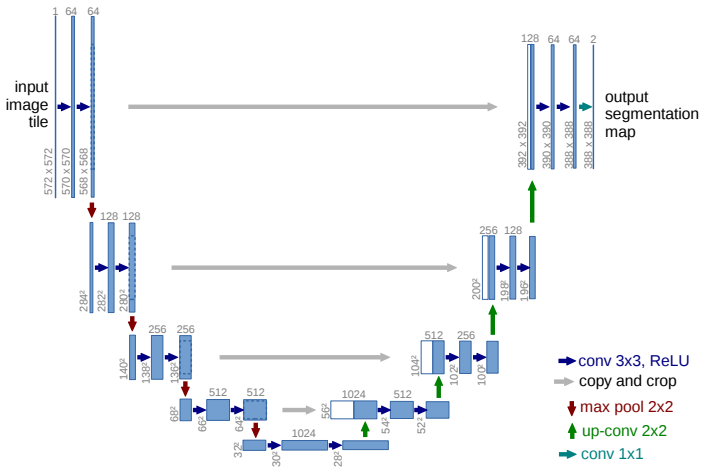

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [58]:
import torch.nn.functional as F
import torch.nn as nn

In [59]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool4 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(512 + 512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.out_conv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pooled = self.pool1(enc1)

        enc2 = self.enc2(enc1_pooled)
        enc2_pooled = self.pool2(enc2)

        enc3 = self.enc3(enc2_pooled)
        enc3_pooled = self.pool3(enc3)

        enc4 = self.enc4(enc3_pooled)
        enc4_pooled = self.pool4(enc4)

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pooled)

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        return self.out_conv(dec1)


In [60]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.


За эту часть задания снижайте баллы, не успеваю в полной мере выполнить его, поэтому рассмотрю только UNet на BCE лоссе, так как BCE показал лучшую метрику на SegNet:

In [61]:
train_losses_UNet = []
val_losses_UNet = []
train_iou_UNet = []
val_iou_UNet = []
epochs_ = []

def train_val(model, optimizer, criterion, epochs, train_dataloader, val_dataloader, device):
    for epoch in tqdm(range(epochs)):
        model.train()
        avg_loss = 0
        processed_data = 0
        iou = 0
        for i, (X_batch, Y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            y_pred = F.sigmoid(Y_pred)
            iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)
            
            avg_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        epoch_loss = avg_loss / processed_data
        train_losses_UNet.append(epoch_loss)
        train_iou_UNet.append(iou / processed_data)

        model.eval()
        avg_loss = 0
        processed_data = 0
        iou = 0
        for i, (X_batch, Y_batch) in enumerate(val_dataloader):
            with torch.no_grad():
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = criterion(Y_pred, Y_batch)

                y_pred = F.sigmoid(Y_pred)
                iou += iou_score(y_pred, Y_batch).item() * Y_batch.size(0)
    
            avg_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)
        epoch_loss = avg_loss / processed_data
        val_losses_UNet.append(epoch_loss)
        val_iou_UNet.append(iou / processed_data)

        epochs_.append(epoch+1)

In [62]:
opt = torch.optim.Adam(unet_model.parameters(), lr=1e-4)

train_val(unet_model, opt, bce_torch_with_logits, 50, train_dataloader, valid_dataloader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

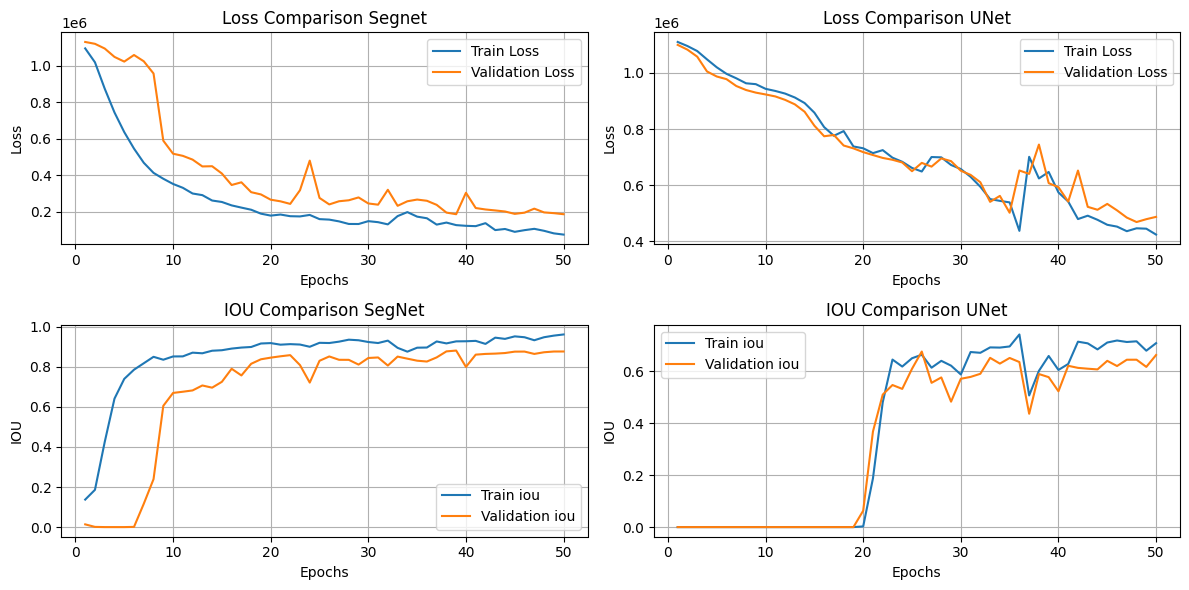

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

(ax1, ax2), (ax3, ax4) = axes

# Сравнение лоссов на трейне и валидации SegNet:
ax1.plot(epochs_, train_losses, label="Train Loss")
ax1.plot(epochs_, val_losses, label="Validation Loss")
ax1.set_title("Loss Comparison Segnet")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid()

# Сравнение лоссов на трейне и валидации UNet:
ax2.plot(epochs_, train_losses_UNet, label="Train Loss")
ax2.plot(epochs_, val_losses_UNet, label="Validation Loss")
ax2.set_title("Loss Comparison UNet")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid()

# Сравнение метрик IOU на трейне и валидации SegNet:
ax3.plot(epochs_, train_iou, label="Train iou")
ax3.plot(epochs_, val_iou, label="Validation iou")
ax3.set_title("IOU Comparison SegNet")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("IOU")
ax3.legend()
ax3.grid()

# Сравнение метрик IOU на трейне и валидации UNet:
ax4.plot(epochs_, train_iou_UNet, label="Train iou")
ax4.plot(epochs_, val_iou_UNet, label="Validation iou")
ax4.set_title("IOU Comparison UNet")
ax4.set_xlabel("Epochs")
ax4.set_ylabel("IOU")
ax4.legend()
ax4.grid()

plt.tight_layout()
plt.show()

Очень странные результаты вышли, думал, что UNet должен по всем параметрам обойти SegNet, но вышло всё наоборот. Возможно, я что-то сделал не так в реализации UNet, хотя вроде не один я столкнулся с таким. Буду рад каким-либо советам! В дальнейшем планирую разбираться с UNet и доделать это задание (сравнить по остальным лоссам). Ещё хочу затестить tversky loss. И может как-нибудь более информативно это всё оформлю, уж слишком сильно мне понравилась эта домашка, жаль, что не рассчитал свои силы и начал поздно делать (не успел реализовать всё, что планировал, пришлось очень торопиться). К сожалению, немного не успел доделать последнее задание до делайна. Спасибо за проверку работы!!!